# Object detection pipeline

This example shows a basic pipeline that performs object detection on a fragment of video and then proposes a method for evaluation of different detectors.

Contents:

1. A minimal object detection pipeline.
2. A pipeline for evaluating model performance (mAP) and execution time.
3. Model selection.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from videoanalytics.pipeline import Pipeline
from videoanalytics.pipeline.sources import VideoReader
from videoanalytics.pipeline.sinks import VideoWriter

## A minimal object detection pipeline

### Configuration

#### Input and output video

We will be using the same video as in the previous examples.
Note: the video used in this example was downloaded from [youtube](https://www.youtube.com/watch?v=WgCe0tMO4lA).

In [3]:
DATA_PATH = "../data/"

# Input
INPUT_VIDEO = DATA_PATH+"/input/test_video.mp4"
START_FRAME = 0
MAX_FRAMES = 100

In [4]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/input/test_video.mp4" type="video/mp4">
    </video>
</div>

In [5]:
# Output
OUTPUT_VIDEO = DATA_PATH+ "/output/test_output.avi"

#### Configuration of object detection components

Object detection needs a trained model. For this example we will be using a tensorflow implementation of YOLOv4 for which the weights shall be provided as a checkpoint/frozen graph.

To visualize bounding boxes, a text file with the names of the classes is also provided. Also, detected bounding boxes are stored in a CSV for later analysis or to work with other algorithms such as SORT.

In [6]:
# Specific components for object detection
from videoanalytics.pipeline.sinks.object_detection import DetectionsAnnotator, DetectionsCSVWriter
from videoanalytics.pipeline.sinks.object_detection.yolo4 import YOLOv4DetectorTF

In [7]:
# Detector

# Object Detector model weights (Tensorflow)
DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-416-tf"
#DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-tiny-416"


# Classes names for Detections Annotator
DETECTOR_CLASSES_FILENAME = DATA_PATH+"object_detection/classes_definitions/coco.txt"

# CSV with Detections filename
DETECTIONS_FILENAME = DATA_PATH+"/output/detections.csv"

### Pipeline instantiation and execution

In [8]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

In [9]:
# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

In [10]:
# 3.3 Save detections to CSV
pipeline.add_component( DetectionsCSVWriter("det_csv_writer",context,filename=DETECTIONS_FILENAME) )

In [11]:
# 3.4 Annotate detections in output video
pipeline.add_component( DetectionsAnnotator("annotator",context,
                                             class_names_filename=DETECTOR_CLASSES_FILENAME,
                                             show_label=True) )

In [12]:
# 3.3 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

In [13]:
# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "det_csv_writer"),
    ("detector", "annotator"),
    ("annotator", "writer")
])

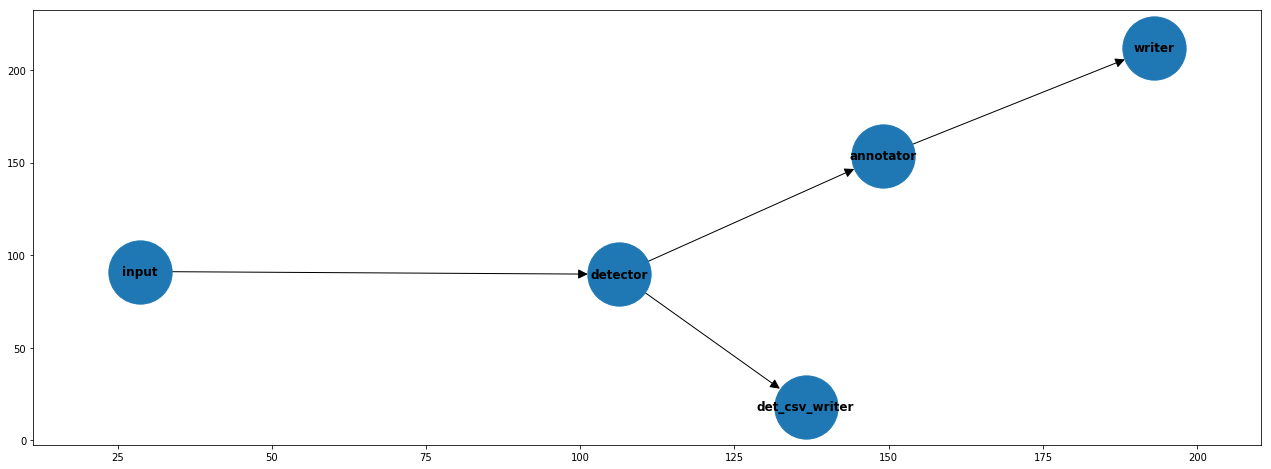

In [14]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [15]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 51.311861097000474


### Evaluation of execution time

Note that most of the execution time is being occupied by the object detector. In the setup being tested, an average of 0.5 seconds per frame (~2FPS) makes it unsuitable for real time.

In the following section a different scheme is proposed to evaluate the performance of the detection, and in the final section both model detection performance and infered time are considered to assist in the configuration of an optimal pipeline for a given scenario.

In [16]:
import pandas as pd
# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

,time [s]
input_avg_dt,0.006368
detector_avg_dt,0.482754
annotator_avg_dt,0.000493
writer_avg_dt,0.021735
det_csv_writer_avg_dt,0.000040


In [17]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               94
Model name:          Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz
Stepping:            3
CPU MHz:             2606.753
CPU max MHz:         3500,0000
CPU min MHz:         800,0000
BogoMIPS:            5199.98
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            6144K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg

### Exploration of results

Display the output video with annotated bounding boxes.

Note: currently XVID format is not supported by jupyter.

In [18]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/output/test_output.avi" type="video/mp4">
    </video>
</div>

By default *DetectionsCSVWriter* stores the results in YOLO normalized format (xc,yc,w,h). 

In [19]:
df_pred_dets = pd.read_csv(DETECTIONS_FILENAME,names=["frame_num","class_idx", "x","y","w","h","score","filename"])
df_pred_dets.head(5)

,frame_num,class_idx,x,y,w,h,score,filename
0,0,0,860.0,361.0,140.0,137.0,0.742915,NaN
1,0,0,696.0,387.0,111.0,104.0,0.620522,NaN
2,1,0,860.0,361.0,140.0,137.0,0.742915,NaN
3,1,0,696.0,387.0,111.0,104.0,0.620522,NaN
4,2,0,862.0,361.0,137.0,137.0,0.657860,NaN


We can convert this to (x0,y0,x1,y1) format with a more convenient format for visualization and interpretation of results with *convert_detections(box_format="xyxy")*.

In [20]:
from videoanalytics.pipeline.sinks.object_detection.utils import convert_detections

df_pred_dets = convert_detections(df_pred_dets,box_format="xyxy")

# Keep relevant columns only
df_pred_dets = df_pred_dets[['frame_num','class_idx','x0','y0','x1','y1','score']]
df_pred_dets.head(5)

,frame_num,class_idx,x0,y0,x1,y1,score
0,0,0,860.0,361.0,1000.0,498.0,0.742915
1,0,0,696.0,387.0,807.0,491.0,0.620522
2,1,0,860.0,361.0,1000.0,498.0,0.742915
3,1,0,696.0,387.0,807.0,491.0,0.620522
4,2,0,862.0,361.0,999.0,498.0,0.657860


## A pipeline for evaluation of results (frame-by-frame evaluation)

The previous example showed how to obtain detections from a video and the average inference time per frame, but it didnt provide a standard metric to evaluate the model precision.

Even if the task being performed is the identification of objects in a video and the relationship between contiguous frames could improve the quality of the detections, the object detector works on individual frames, so this example modifies the previous pipeline to read files from a directory containing images for which the expected (ground truth) detections are provided in separate text files.

In [21]:
from glob import glob 
import os

# Each .jpg in test directory has a matching .txt file with the annotations
TEST_IMG_SEQ_PATH = DATA_PATH+"/input/test_img_seq"
glob(TEST_IMG_SEQ_PATH+"/img*.*")[:5]

['../data//input/test_img_seq/img8243.jpg',
 '../data//input/test_img_seq/img7463.txt',
 '../data//input/test_img_seq/img16689.txt',
 '../data//input/test_img_seq/img1603.jpg',
 '../data//input/test_img_seq/img16322.txt']

In [22]:
img_list = glob(TEST_IMG_SEQ_PATH+"/img*.jpg")
img_list

['../data//input/test_img_seq/img8243.jpg',
 '../data//input/test_img_seq/img1603.jpg',
 '../data//input/test_img_seq/img10956.jpg',
 '../data//input/test_img_seq/img11071.jpg',
 '../data//input/test_img_seq/img365.jpg',
 '../data//input/test_img_seq/img2334.jpg',
 '../data//input/test_img_seq/img8722.jpg',
 '../data//input/test_img_seq/img16322.jpg',
 '../data//input/test_img_seq/img12419.jpg',
 '../data//input/test_img_seq/img8240.jpg',
 '../data//input/test_img_seq/img7463.jpg',
 '../data//input/test_img_seq/img9859.jpg',
 '../data//input/test_img_seq/img16689.jpg',
 '../data//input/test_img_seq/img5320.jpg',
 '../data//input/test_img_seq/img10989.jpg',
 '../data//input/test_img_seq/img10606.jpg',
 '../data//input/test_img_seq/img15269.jpg',
 '../data//input/test_img_seq/img2264.jpg',
 '../data//input/test_img_seq/img12115.jpg']

### Pipeline instantiation and execution

This step is similar to the other examples, with the only difference that in this case the input and outputs are a sequence of images.

*ImageSequenceReader* and *ImageWriter* are used instead of *VideoReader* and *VideoFileWriter*.

In [23]:
from videoanalytics.pipeline.sources import ImageSequenceReader
from videoanalytics.pipeline.sinks import ImageWriter

In [24]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( ImageSequenceReader( "input",context, img_seq=img_list))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 Save detections to CSV
pipeline.add_component( DetectionsCSVWriter("det_csv_writer",context,filename=DETECTIONS_FILENAME) )

# 3.4 Annotate detections in output video
pipeline.add_component( DetectionsAnnotator("annotator",context,
                                             class_names_filename=DETECTOR_CLASSES_FILENAME,
                                             show_label=True) )

# 3.5 Sink
pipeline.add_component(ImageWriter("writer",context,output_path= DATA_PATH+"/output/"))

In [25]:
# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "det_csv_writer"),
    ("detector", "annotator"),
    ("annotator", "writer")
])

In [26]:
pipeline.optimize()

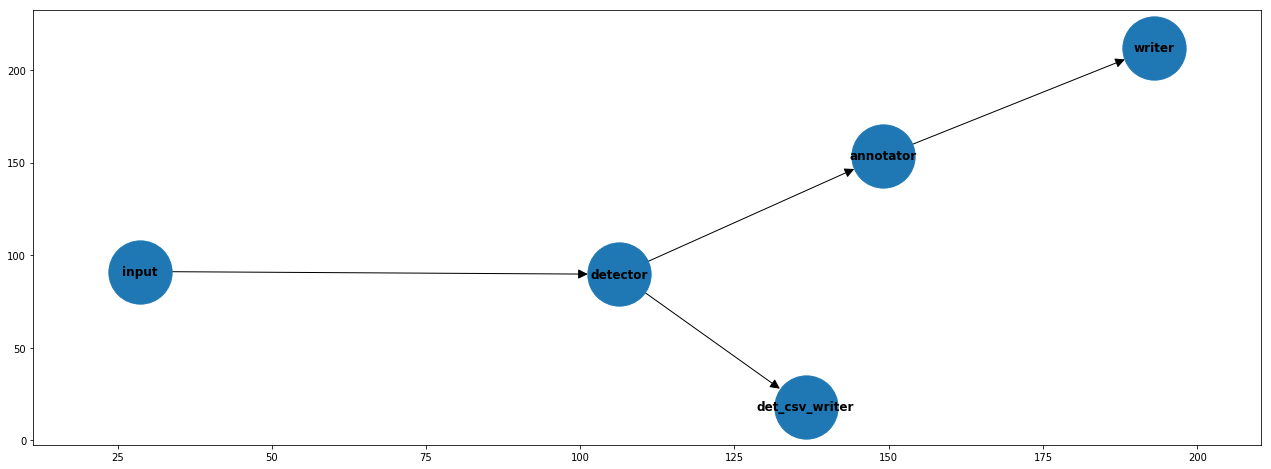

In [27]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [28]:
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 11.51667647999966


### Evaluation of results

Steps:

1. Build a dataframe with the bounding boxes for the ground truth.
2. Build a dataframe with the bounding boxes for the predictions.
3. Evaluate using different variants of mAP.

1. Build a dataframe with the bounding boxes for the ground truth.

In [29]:
det_list = [os.path.splitext(filename)[0]+'.txt' for filename in img_list]
det_list

['../data//input/test_img_seq/img8243.txt',
 '../data//input/test_img_seq/img1603.txt',
 '../data//input/test_img_seq/img10956.txt',
 '../data//input/test_img_seq/img11071.txt',
 '../data//input/test_img_seq/img365.txt',
 '../data//input/test_img_seq/img2334.txt',
 '../data//input/test_img_seq/img8722.txt',
 '../data//input/test_img_seq/img16322.txt',
 '../data//input/test_img_seq/img12419.txt',
 '../data//input/test_img_seq/img8240.txt',
 '../data//input/test_img_seq/img7463.txt',
 '../data//input/test_img_seq/img9859.txt',
 '../data//input/test_img_seq/img16689.txt',
 '../data//input/test_img_seq/img5320.txt',
 '../data//input/test_img_seq/img10989.txt',
 '../data//input/test_img_seq/img10606.txt',
 '../data//input/test_img_seq/img15269.txt',
 '../data//input/test_img_seq/img2264.txt',
 '../data//input/test_img_seq/img12115.txt']

In [30]:
from videoanalytics.pipeline.sinks.object_detection.utils import load_detections_from_file_list

df_gt_dets = load_detections_from_file_list(det_list)
df_gt_dets.head(5)

,filename,frame_num,class_idx,x,y,w,h,img_w,img_h,x0,x1,y0,y1,difficult,crowd
0,img8243,0,0,1287.99936,804.99960,338.00064,525.99996,1920,1080,1118.99904,1456.99968,541.99962,1067.99958,0,0
1,img8243,0,0,612.00000,460.00008,110.00064,216.00000,1920,1080,556.99968,667.00032,352.00008,568.00008,0,0
2,img8243,0,0,706.99968,426.99960,120.00000,185.99976,1920,1080,646.99968,766.99968,333.99972,519.99948,0,0
3,img8243,0,0,1134.00000,456.99984,150.00000,253.99980,1920,1080,1059.00000,1209.00000,329.99994,583.99974,0,0
4,img8243,0,1,1651.49952,737.49960,301.00032,388.99980,1920,1080,1500.99936,1801.99968,542.99970,931.99950,0,0


2. Build a dataframe with the bounding boxes for the predictions.

In [31]:
df_pred_dets = pd.read_csv(DETECTIONS_FILENAME,names=["frame_num","class_idx", "x","y","w","h","score","filename"])
df_pred_dets = convert_detections(df_pred_dets)
df_pred_dets.head(5)

,frame_num,class_idx,x,y,w,h,score,filename,x0,y0,x1,y1
0,0,0,1125.0,559.0,305.0,483.0,0.718696,img8243,1125.0,559.0,1430.0,1042.0
1,0,0,641.0,341.0,130.0,127.0,0.672495,img8243,641.0,341.0,771.0,468.0
2,1,0,1191.0,365.0,90.0,134.0,0.589164,img1603,1191.0,365.0,1281.0,499.0
3,2,0,0.0,537.0,362.0,481.0,0.862434,img10956,0.0,537.0,362.0,1018.0
4,2,0,1202.0,800.0,625.0,280.0,0.629002,img10956,1202.0,800.0,1827.0,1080.0


Test with a sample image for class 0 (person).

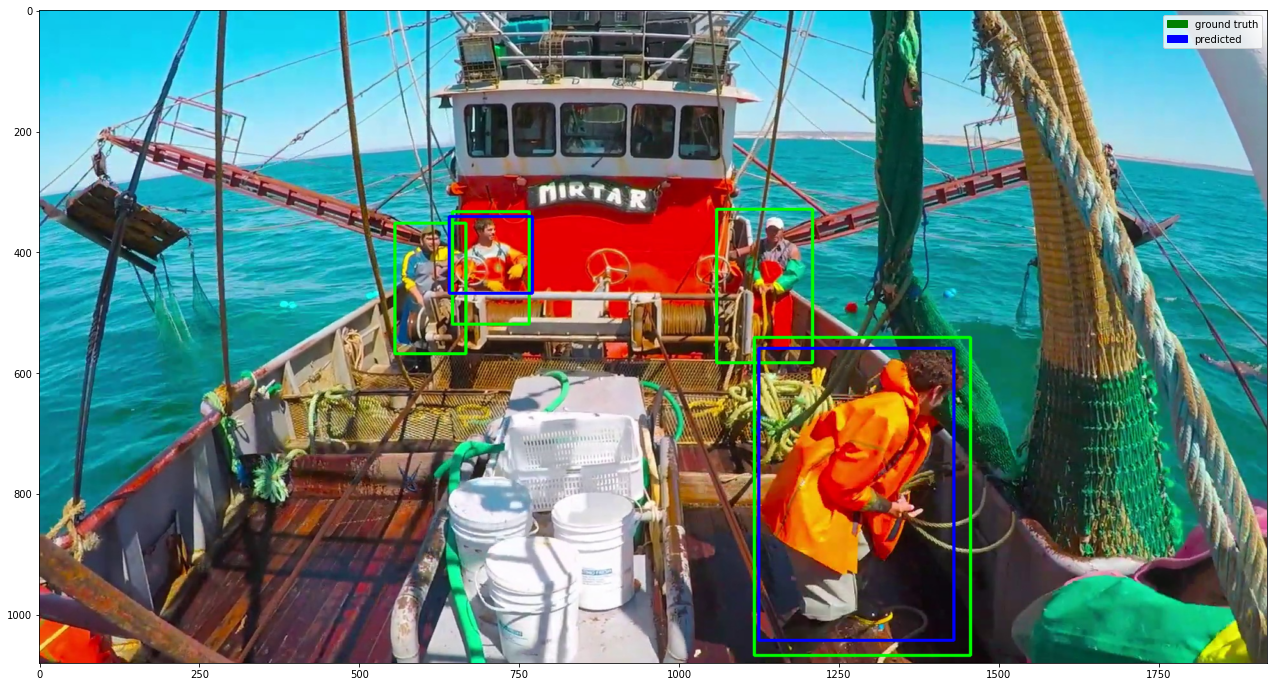

In [32]:
from videoanalytics.pipeline.sinks.object_detection.utils import plot_predictions_vs_ground_truth
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,1,figsize=(22,12))
plot_predictions_vs_ground_truth(df_gt_dets,df_pred_dets,
                                 img_path='../data//input/test_img_seq/',
                                 img_name='img8243', 
                                 class_idx=0,
                                 ax=axes);

Evaluate using different variants of mAP.

In [33]:
from videoanalytics.pipeline.sinks.object_detection.evaluation import evaluate_object_detection_predictions

df_od_metrics = evaluate_object_detection_predictions(
    df_gt_dets, df_pred_dets, classes = [0],model_name="yolov4")
df_od_metrics

,VOC PASCAL,VOC PASCAL (all points),COCO
yolov4,0.545455,0.5,0.254455


## Model selection

The following example defines a function to instantiate a minimal object detection pipeline specyfing the weights and classes file, which is the used to test a set of models and collect their metrics of interest (the mAPs and average per frame/total execution times).

In [34]:
def make_pipeline(context, eval_img_list, weights_filename,detections_csv_filename,detector_classes_filename,
                  save_imgs=False,output_img_path=None):
    pipeline = Pipeline()
    connections = [
        ("input", "detector"),
        ("detector", "det_csv_writer")
    ]
    pipeline.add_component( ImageSequenceReader( "input",context, img_seq=eval_img_list))
    pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=weights_filename) )
    pipeline.add_component( DetectionsCSVWriter("det_csv_writer",context,filename=detections_csv_filename) )
    if save_imgs:
        pipeline.add_component( DetectionsAnnotator("annotator",context,
                                             class_names_filename=detector_classes_filename,
                                             show_label=True) )    
        pipeline.add_component(ImageWriter("writer",context,output_path=output_img_path))
        connections+=[
            ("detector", "annotator"),
            ("annotator", "writer")
        ]
    
    pipeline.set_connections(connections)
    return pipeline

Reload ground truth dataframe as an previous example.

In [35]:
# Ground truth
det_list = [os.path.splitext(filename)[0]+'.txt' for filename in img_list]
df_gt_dets = load_detections_from_file_list(det_list)
df_gt_dets.head(5)

,filename,frame_num,class_idx,x,y,w,h,img_w,img_h,x0,x1,y0,y1,difficult,crowd
0,img8243,0,0,1287.99936,804.99960,338.00064,525.99996,1920,1080,1118.99904,1456.99968,541.99962,1067.99958,0,0
1,img8243,0,0,612.00000,460.00008,110.00064,216.00000,1920,1080,556.99968,667.00032,352.00008,568.00008,0,0
2,img8243,0,0,706.99968,426.99960,120.00000,185.99976,1920,1080,646.99968,766.99968,333.99972,519.99948,0,0
3,img8243,0,0,1134.00000,456.99984,150.00000,253.99980,1920,1080,1059.00000,1209.00000,329.99994,583.99974,0,0
4,img8243,0,1,1651.49952,737.49960,301.00032,388.99980,1920,1080,1500.99936,1801.99968,542.99970,931.99950,0,0


Collect results in this datframe.

In [36]:
columns = list(df_od_metrics.columns)+["avg_exec_time","total_exec_time"]

In [37]:
df_model_sel_results = pd.DataFrame(columns=columns)
df_model_sel_results

,VOC PASCAL,VOC PASCAL (all points),COCO,avg_exec_time,total_exec_time


Define paths with model parameters (for this example only YOLOv4 tensorflow implementation variants are considered) and temporary outputs.

In [38]:
CHECKPOINTS_PATH = "../data/object_detection/checkpoints/"
OUTPUT_PATH = DATA_PATH+"/output/"

Dictionary containing models to test.

In [39]:
models_to_test = {
    "yolov4": {
        "weights": CHECKPOINTS_PATH + "yolov4-416-tf"
    },
    "yolov4-tiny": {
        "weights": CHECKPOINTS_PATH + "yolov4-tiny-416"
    },
}  

Run each model in the same test set.

In [40]:
for model_name,model_params in models_to_test.items():
    print("Evaluating model {}".format(model_name))
    detections_csv_filename=OUTPUT_PATH+model_name+".csv"
    
    # 1. Build pipeline
    context = {}
    pipeline = make_pipeline(context, img_list, weights_filename=model_params["weights"],
                             detections_csv_filename=detections_csv_filename,
                             detector_classes_filename=DETECTOR_CLASSES_FILENAME,                             
                             save_imgs=False)
    # 2. Execute pipeline    
    pipeline.execute()
    total_exec_time = pipeline.get_total_execution_time()
    
    df_pipeline_metrics = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
    
    # 3. Read predictions
    df_pred_dets = pd.read_csv(detections_csv_filename, 
                               names=["frame_num","class_idx", "x","y","w","h","score","filename"])
    df_pred_dets = convert_detections(df_pred_dets)
        
    # 4. Evaluate and append results
    df_od_metrics = evaluate_object_detection_predictions( df_gt_dets, df_pred_dets, 
                                                           classes = [0],model_name=model_name)
    df_od_metrics['avg_exec_time'] = df_pipeline_metrics.loc['detector_avg_dt'][0]
    df_od_metrics['total_exec_time'] = total_exec_time
    
    df_model_sel_results = df_model_sel_results.append( df_od_metrics )

Evaluating model yolov4


  0%|          | 0/100.0 [00:00<?, ?it/s]

Evaluating model yolov4-tiny


  0%|          | 0/100.0 [00:00<?, ?it/s]

In [41]:
df_model_sel_results

,VOC PASCAL,VOC PASCAL (all points),COCO,avg_exec_time,total_exec_time
yolov4,0.545455,0.5,0.254455,0.494261,10.047086
yolov4-tiny,0.000000,0.0,0.000000,0.065422,1.896999
